This project is a final part of the IBM Applied Data Science specialization. We use the foursquare API to get location data and use it to compare neighbourhoods for similarity. This allows us to get insights on the amenities available in a certain neighbourhood and how these amenities compare across other neighbourhoods. We can then decide which neighbourhoods are better than others.

In [1]:
import pandas as pd
import numpy as np

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [3]:
import requests
from bs4 import BeautifulSoup

In [7]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
data = requests.get(url).text
soup = BeautifulSoup(data, 'lxml')

In [195]:
# print(soup.prettify())

In [196]:
table = soup.find('table', {'class':'wikitable sortable'})
# table

In [37]:
def parse_table(table):
    
    n_rows, n_cols = 0, 0
    col_names = []
    
    for row in table.find_all('tr'):
        
        td_tags = row.find_all('td')
        if len(td_tags) > 0:
            n_rows +=1
            if n_cols == 0:
                n_cols = len(td_tags)
                
        th_tags = row.find_all('th')
        if len(th_tags)>0 and len(col_names) == 0:
            col_names = [th.get_text().strip('\n') for th in th_tags]
            
#     print(col_names)
    df = pd.DataFrame(columns=col_names, index=range(0, n_rows))
    
    row_marker = 0
    for row in table.find_all('tr'):
        
        col_marker = 0
        columns = row.find_all('td')
        
        for col in columns:
#             print(col.get_text())
            df.iat[row_marker,col_marker] = col.get_text().strip('\n')
            col_marker +=1
            
        if len(columns) > 0:
            row_marker += 1
            
    return df
       

In [57]:
df = parse_table(table)

In [58]:
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [59]:
df.tail()

,Postal Code,Borough,Neighbourhood
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."
179,M9Z,Not assigned,Not assigned


In [60]:
df.shape

(180, 3)

In [61]:
len(df['Postal Code'].unique())

180

# Preprocess scraped dataframe

In [62]:
# ignore rows where boroigh is not assigned
df = df.loc[df['Borough'] != 'Not assigned' ]

In [63]:
df.shape

(103, 3)

In [64]:
df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [65]:
df.loc[df['Neighbourhood'] == 'Not assigned' ]

,Postal Code,Borough,Neighbourhood


In [66]:
# def clean_hood(row):
#     borough = row['Borough']
#     nbrhood = row['Neighbourhood']
#     hood = ''
#     if nbrhood == 'Not assigned':
#         hood = borough
#     return hood

# df['Neighbourhood'] = df.apply(lambda x: clean_hood(x))

In [67]:
df.reset_index(drop=True, inplace=True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [68]:
df.shape # final shape

(103, 3)

# Get the coordinates of the neighbourhoods

In [69]:
!pip3 install geocoder
import geocoder

     |################################| 98 kB 888 kB/s eta 0:00:011
You should consider upgrading via the '/home/rachneet/anaconda3/bin/python -m pip install --upgrade pip' command.


In [78]:
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

     |################################| 111 kB 8.7 MB/s eta 0:00:01
You should consider upgrading via the '/home/rachneet/anaconda3/bin/python -m pip install --upgrade pip' command.


In [86]:
# test location
address = 'Downtown Toronto, Central Bay Street'

geolocator = Nominatim(user_agent="proj_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.6614251 -79.3860669


In [87]:
# get location data from given .csv file because this method is unreliable

df_loc = pd.read_csv("Geospatial_Coordinates.csv")

In [88]:
df_loc.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [118]:
# join loaction dataframe with our original data based on the postal code

data = pd.merge(df, df_loc, on=['Postal Code'])

In [119]:
data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


# Explore Neighbourhoods

In [120]:
# using boroughs that contain the word Toronto
b = data['Borough'].values
boroughs = []
for borough in b:
    if 'Toronto' in borough:
        boroughs.append(borough)

x = set(boroughs)
x

{'Central Toronto', 'Downtown Toronto', 'East Toronto', 'West Toronto'}

In [131]:
# using boroughs that contain the word Toronto
# this will be our final data
toronto_data = data.loc[data.Borough.isin(x)].reset_index(drop=True)

In [132]:
toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [133]:
toronto_data.shape

(39, 5)

In [134]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_data['Borough'].unique()),
        toronto_data.shape[0]
    )
)

The dataframe has 4 boroughs and 39 neighborhoods.


In [124]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip3 install folium
import folium # map rendering library

     |################################| 93 kB 236 kB/s eta 0:00:011
You should consider upgrading via the '/home/rachneet/anaconda3/bin/python -m pip install --upgrade pip' command.


In [126]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 43.6534817, -79.3839347.


In [135]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [130]:
# define foursquare credentials

CLIENT_ID = '1FWX5K0YPY20E0FTPHP0MO5O1VFFA1M44YOODLY4ABYBF5AT' # your Foursquare ID
CLIENT_SECRET = 'WYULF5FWVQ2NHJEUUZTSEH5EHHDRXBNSKVQ02ZSPM4FEITCQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 1FWX5K0YPY20E0FTPHP0MO5O1VFFA1M44YOODLY4ABYBF5AT
CLIENT_SECRET:WYULF5FWVQ2NHJEUUZTSEH5EHHDRXBNSKVQ02ZSPM4FEITCQ


In [137]:
# get nbrhood name
toronto_data.loc[0, 'Neighbourhood']

'Regent Park, Harbourfront'

In [138]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.6542599, -79.3606359.


In [139]:
# top 100 venues near Regent park, Harbour front
LIMIT=100
radius=500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                                                                    CLIENT_SECRET,
                                                                                                                                    neighborhood_latitude,
                                                                                                                                    neighborhood_longitude,
                                                                                                                                    VERSION,
                                                                                                                                    neighborhood_name,
                                                                                                                                    radius,
                                                                                                                                    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=1FWX5K0YPY20E0FTPHP0MO5O1VFFA1M44YOODLY4ABYBF5AT&client_secret=WYULF5FWVQ2NHJEUUZTSEH5EHHDRXBNSKVQ02ZSPM4FEITCQ&ll=43.6542599,-79.3606359&v=20180605&query=Regent Park, Harbourfront&radius=500&limit=100'

In [140]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f949bf9841fee376f346f52'},
 'response': {'warning': {'text': 'There aren\'t a lot of results for "Regent Park, Harbourfront." Try something more general, reset your filters, or expand the search area.'},
  'headerLocation': 'Corktown',
  'headerFullLocation': 'Corktown, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'query': 'regent park harbourfront',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.6587599045, 'lng': -79.3544279001486},
   'sw': {'lat': 43.6497598955, 'lng': -79.36684389985142}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c16a548955976b0cadea4f6',
       'name': 'Parliament Square Park',
       'location': {'address': '44 Parliament Street',
        'lat': 43.65026388338689,
        'ln

In [141]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [143]:
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/rachneet/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """


,name,categories,lat,lng
0,Parliament Square Park,Park,43.650264,-79.362195
1,Orphan's Greenspace Dog Park,Dog Run,43.654654,-79.362501


In [144]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

2 venues were returned by Foursquare.


# Explore neighbourhoods in Toronto

In [145]:
# function to repeat the process for all neighbourhoods in Toronto

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [146]:
toronto_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [147]:
# get all venues
names = toronto_data['Neighbourhood']
lats = toronto_data['Latitude']
longs = toronto_data['Longitude']
toronto_venues = getNearbyVenues(names, lats, longs)

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [148]:
print(toronto_venues.shape)
toronto_venues.head()

(1624, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [150]:
# venues per nbrhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,55,55,55,55,55,55
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,68,68,68,68,68,68
Christie,16,16,16,16,16,16
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


In [151]:
# number of unique categories from all venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 237 uniques categories.


# Analyze each neighbourhood

In [152]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
toronto_onehot.shape

(1624, 237)

In [154]:
#grouping nbrhoods to get the frequency of venue categories

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.018182,0.000000,0.000000,0.000000,0.00
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0625,0.0625,0.0625,0.125,0.125,0.0625,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
4,Central Bay Street,0.014706,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.014706,0.000000,0.000000,0.014706,0.00
5,Christie,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
6,Church and Wellesley,0.026667,0.013333,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.013333,...,0.013333,0.013333,0.000000,0.000000,0.00,0.000000,0.000000,0.013333,0.000000,0.00
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.040000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.00
8,Davisville,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.030303,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
9,Davisville North,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00


In [155]:
toronto_grouped.shape

(39, 237)

In [156]:
# get tpo venues in each neighbourhood

tem = toronto_grouped[toronto_grouped['Neighborhood'] == 'Berczy Park'].T.reset_index()
tem.columns = ['venue', 'freq']
tem.iloc[1:]

,venue,freq
1,Yoga Studio,0
2,Afghan Restaurant,0
3,Airport,0
4,Airport Food Court,0
5,Airport Gate,0
...,...,...
232,Vegetarian / Vegan Restaurant,0.0181818
233,Video Game Store,0
234,Vietnamese Restaurant,0
235,Wine Bar,0


In [157]:
# getting top 5 venues
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
         venue  freq
0  Coffee Shop  0.09
1     Beer Bar  0.04
2       Bakery  0.04
3   Restaurant  0.04
4  Cheese Shop  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1       Nightclub  0.09
2     Coffee Shop  0.09
3  Breakfast Spot  0.09
4             Gym  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0           Pizza Place  0.06
1      Recording Studio  0.06
2            Skate Park  0.06
3  Fast Food Restaurant  0.06
4                  Park  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0       Airport Lounge  0.12
1      Airport Service  0.12
2  Rental Car Location  0.06
3      Harbor / Marina  0.06
4     Sculpture Garden  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.18
1   

In [158]:
# now let's put this into a dataframe

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [185]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Bakery,Restaurant,Cheese Shop,Beer Bar,Cocktail Bar,Seafood Restaurant,Farmers Market,Breakfast Spot,Pharmacy
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Nightclub,Coffee Shop,Grocery Store,Burrito Place,Bakery,Intersection,Italian Restaurant,Restaurant
2,"Business reply mail Processing Centre, South C...",Park,Pizza Place,Skate Park,Brewery,Burrito Place,Farmers Market,Fast Food Restaurant,Restaurant,Butcher,Recording Studio
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Sculpture Garden,Boutique,Plane,Rental Car Location,Coffee Shop,Boat or Ferry,Harbor / Marina,Bar
4,Central Bay Street,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Burger Joint,Department Store,Bubble Tea Shop,Thai Restaurant,Japanese Restaurant,Salad Place


# Cluster Neighbourhoods

In [160]:
# set number of clusters # random choice at first
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

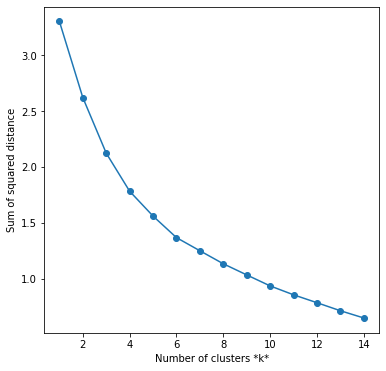

In [174]:
# analyze perfromance of kmeans using the elbow method

import matplotlib.pyplot as plt
%matplotlib inline

# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(toronto_grouped_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

Difficult to still tell the k value as the curve is not flattening out but k=5 seems a plausible value

In [186]:
# Let's try with k=5
# set number of clusters # random choice at first
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([4, 4, 0, 4, 4, 0, 4, 4, 0, 4], dtype=int32)

In [187]:
######### add cluster numbers to original set

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,4,Coffee Shop,Park,Pub,Bakery,Café,Theater,Breakfast Spot,Brewery,Spa,Beer Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,4,Coffee Shop,Yoga Studio,Café,Smoothie Shop,Beer Bar,Italian Restaurant,Sandwich Place,Restaurant,Distribution Center,Diner
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,4,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Pizza Place,Ramen Restaurant,Bookstore,Middle Eastern Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,4,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,Beer Bar,American Restaurant,Lingerie Store,Hotel,Cosmetics Shop
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Pub,Trail,Health Food Store,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant


In [188]:
toronto_merged['Cluster Labels'].values.tolist()

[4,
 4,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 0,
 4,
 4,
 0,
 4,
 4,
 0,
 4,
 4,
 3,
 2,
 4,
 1,
 4,
 4,
 0,
 4,
 0,
 4,
 0,
 1,
 4,
 0,
 4,
 1,
 4,
 0,
 4,
 4,
 0]

In [189]:
#### let's visualize our clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine Clusters

In [190]:
# examine distinguishing venues

# restaurant area
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,East Toronto,0,Pub,Trail,Health Food Store,Women's Store,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Doner Restaurant
7,Downtown Toronto,0,Grocery Store,Café,Park,Baby Store,Nightclub,Athletics & Sports,Restaurant,Coffee Shop,Candy Store,Italian Restaurant
9,West Toronto,0,Pharmacy,Bakery,Grocery Store,Supermarket,Middle Eastern Restaurant,Music Venue,Café,Brewery,Bar,Bank
12,East Toronto,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Pub,Pizza Place,Lounge
15,East Toronto,0,Park,Pizza Place,Fast Food Restaurant,Pub,Fish & Chips Shop,Steakhouse,Sushi Restaurant,Burrito Place,Italian Restaurant,Restaurant
24,Central Toronto,0,Sandwich Place,Café,Coffee Shop,History Museum,Liquor Store,Burger Joint,Indian Restaurant,BBQ Joint,Donut Shop,Middle Eastern Restaurant
26,Central Toronto,0,Sandwich Place,Dessert Shop,Pizza Place,Gym,Italian Restaurant,Sushi Restaurant,Café,Coffee Shop,Toy / Game Store,Indoor Play Area
28,West Toronto,0,Coffee Shop,Café,Italian Restaurant,Pub,Pizza Place,Sushi Restaurant,French Restaurant,Diner,Bar,Bank
31,Central Toronto,0,Coffee Shop,Supermarket,Restaurant,Bagel Shop,Sushi Restaurant,Bank,Fried Chicken Joint,Pizza Place,American Restaurant,Liquor Store
35,Downtown Toronto,0,Coffee Shop,Restaurant,Café,Pizza Place,Chinese Restaurant,Pub,Italian Restaurant,Bakery,Market,Park


In [191]:
# popular area for parks and fun activities

toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Central Toronto,1,Park,Sushi Restaurant,Jewelry Store,Trail,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
29,Central Toronto,1,Trail,Playground,Women's Store,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
33,Downtown Toronto,1,Park,Trail,Playground,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


In [192]:
# area for music related activities

toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Central Toronto,2,Music Venue,Garden,Women's Store,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


In [193]:
# area with park and swimming spots

toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,3,Park,Swim School,Bus Line,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


In [194]:
# downtown area where coffee shops are prvelant

toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,4,Coffee Shop,Park,Pub,Bakery,Café,Theater,Breakfast Spot,Brewery,Spa,Beer Store
1,Downtown Toronto,4,Coffee Shop,Yoga Studio,Café,Smoothie Shop,Beer Bar,Italian Restaurant,Sandwich Place,Restaurant,Distribution Center,Diner
2,Downtown Toronto,4,Clothing Store,Coffee Shop,Café,Bubble Tea Shop,Cosmetics Shop,Japanese Restaurant,Pizza Place,Ramen Restaurant,Bookstore,Middle Eastern Restaurant
3,Downtown Toronto,4,Coffee Shop,Café,Cocktail Bar,Restaurant,Gastropub,Beer Bar,American Restaurant,Lingerie Store,Hotel,Cosmetics Shop
5,Downtown Toronto,4,Coffee Shop,Bakery,Restaurant,Cheese Shop,Beer Bar,Cocktail Bar,Seafood Restaurant,Farmers Market,Breakfast Spot,Pharmacy
6,Downtown Toronto,4,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Burger Joint,Department Store,Bubble Tea Shop,Thai Restaurant,Japanese Restaurant,Salad Place
8,Downtown Toronto,4,Coffee Shop,Café,Restaurant,Hotel,Bar,Gym,Clothing Store,Thai Restaurant,Juice Bar,Concert Hall
10,Downtown Toronto,4,Coffee Shop,Aquarium,Hotel,Café,Restaurant,Fried Chicken Joint,Scenic Lookout,Brewery,Music Venue,Park
11,West Toronto,4,Bar,Coffee Shop,Vietnamese Restaurant,Restaurant,Café,Asian Restaurant,Men's Store,Cupcake Shop,Record Shop,Pizza Place
13,Downtown Toronto,4,Coffee Shop,Hotel,Restaurant,Café,American Restaurant,Seafood Restaurant,Salad Place,Japanese Restaurant,Asian Restaurant,Concert Hall
